# Probabilistic Customer Lifetime Value Modeling

**Author:** Harpinder Singh  
**Dataset:** UCI Online Retail II (UK E-Commerce)  
**Objective:** Build probabilistic models to predict future purchase behavior and customer lifetime value

---

## Table of Contents
1. [Environment Setup](#1.-Environment-Setup)
2. [Load Prepared Data](#2.-Load-Prepared-Data)
3. [Traditional RFM Baseline](#3.-Traditional-RFM-Baseline)
4. [Probabilistic Theory: BG/NBD Model](#4.-Probabilistic-Theory:-BG/NBD-Model)
5. [Implement BG/NBD Model](#5.-Implement-BG/NBD-Model)
6. [Gamma-Gamma Model for Monetary Value](#6.-Gamma-Gamma-Model-for-Monetary-Value)
7. [Calculate Customer Lifetime Value](#7.-Calculate-Customer-Lifetime-Value)
8. [Validate Predictions on 2011 Data](#8.-Validate-Predictions-on-2011-Data)
9. [Export Results](#9.-Export-Results)

---

## 1. Environment Setup

╔════════════════════════════════════════════════════════════════╗
║                    ENVIRONMENT CONFIGURATION                    ║
╚════════════════════════════════════════════════════════════════╝

In [1]:
# Standard library imports
import warnings
from pathlib import Path
from datetime import datetime, timedelta

# Data manipulation
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Probabilistic modeling
from lifetimes import BetaGeoFitter, GammaGammaFitter
from lifetimes.utils import summary_data_from_transaction_data
from lifetimes.plotting import plot_frequency_recency_matrix, plot_probability_alive_matrix

# Model persistence
import pickle

#Pickle library
import dill
import json

# Configuration
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: f'{x:.4f}')

# Plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Random seed
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("✅ Environment configured successfully")
print(f"   Numpy: {np.__version__}")
print(f"   Pandas: {pd.__version__}")

✅ Environment configured successfully
   Numpy: 1.26.4
   Pandas: 2.3.3


In [2]:
# ┌────────────────────────────────────────────────────────────┐
# │ Directory Structure Setup                                  │
# └────────────────────────────────────────────────────────────┘

# Define project root
PROJECT_ROOT = Path.cwd()
if PROJECT_ROOT.name == 'notebooks':
    PROJECT_ROOT = PROJECT_ROOT.parent

# Define directories
DIR_DATA_PROCESSED = PROJECT_ROOT / 'data' / 'processed'
DIR_MODELS = PROJECT_ROOT / 'models'
DIR_RESULTS = PROJECT_ROOT / 'results'
DIR_FIGURES = PROJECT_ROOT / 'results' / 'figures'

# Create directories
for directory in [DIR_MODELS, DIR_RESULTS, DIR_FIGURES]:
    directory.mkdir(parents=True, exist_ok=True)

print("✅ Directory structure verified")
print(f"   Project root: {PROJECT_ROOT}")
print(f"   Processed data: {DIR_DATA_PROCESSED}")
print(f"   Models: {DIR_MODELS}")

✅ Directory structure verified
   Project root: d:\Courses\Workstation\Github\Working Projects\GitHub Project 3 - Customer Churn\Customer_Segmentation_Retention_Analysis
   Processed data: d:\Courses\Workstation\Github\Working Projects\GitHub Project 3 - Customer Churn\Customer_Segmentation_Retention_Analysis\data\processed
   Models: d:\Courses\Workstation\Github\Working Projects\GitHub Project 3 - Customer Churn\Customer_Segmentation_Retention_Analysis\models


---

## 2. Load Prepared Data

╔════════════════════════════════════════════════════════════════╗
║                      DATA LOADING                               ║
╚════════════════════════════════════════════════════════════════╝

In [3]:
# ┌────────────────────────────────────────────────────────────┐
# │ Load Training Data                                         │
# └────────────────────────────────────────────────────────────┘

print("Loading datasets...\n")

# Load training transactions
train_data = pd.read_csv(DIR_DATA_PROCESSED / 'train.csv', parse_dates=['InvoiceDate'])
print(f"✅ Training data loaded: {train_data.shape}")
print(f"   Date range: {train_data['InvoiceDate'].min()} to {train_data['InvoiceDate'].max()}")
print(f"   Unique customers: {train_data['CustomerID'].nunique():,}")

# Load validation transactions
val_data = pd.read_csv(DIR_DATA_PROCESSED / 'validation.csv', parse_dates=['InvoiceDate'])
print(f"\n✅ Validation data loaded: {val_data.shape}")
print(f"   Date range: {val_data['InvoiceDate'].min()} to {val_data['InvoiceDate'].max()}")
print(f"   Unique customers: {val_data['CustomerID'].nunique():,}")

# Load RFM features
rfm = pd.read_csv(DIR_DATA_PROCESSED / 'rfm_features.csv')
print(f"\n✅ RFM features loaded: {rfm.shape}")

print("\n" + "="*80)
print("First few customers:")
display(rfm.head())

Loading datasets...

✅ Training data loaded: (23942, 11)
   Date range: 2010-12-01 08:26:00 to 2010-12-23 16:06:00
   Unique customers: 815

✅ Validation data loaded: (330379, 11)
   Date range: 2011-01-04 10:00:00 to 2011-12-09 12:49:00
   Unique customers: 3,813

✅ RFM features loaded: (815, 9)

First few customers:


,CustomerID,Recency,Frequency,Monetary,FirstPurchase,LastPurchase,AvgOrderValue,AvgBasketSize,Tenure
0,12747,10,2,706.2700,2010-12-05 15:38:00,2010-12-13 10:41:00,47.0847,14.2000,7
1,12748,0,35,4228.1300,2010-12-01 12:48:00,2010-12-23 15:32:00,6.3295,4.2530,22
2,12826,14,1,155.0000,2010-12-09 15:21:00,2010-12-09 15:21:00,17.2222,8.8889,0
3,12829,9,1,85.7500,2010-12-14 14:54:00,2010-12-14 14:54:00,17.1500,25.0000,0
4,12838,22,1,390.7900,2010-12-01 11:57:00,2010-12-01 11:57:00,6.6236,3.8644,0


---

## 3. Traditional RFM Baseline

╔════════════════════════════════════════════════════════════════╗
║                   TRADITIONAL RFM APPROACH                      ║
╚════════════════════════════════════════════════════════════════╝

### The Problem with Traditional RFM:

Traditional RFM is **backward-looking**:
- **Recency:** When did they *last* buy?
- **Frequency:** How many times *have* they bought?
- **Monetary:** How much *have* they spent?

But we need **forward-looking** predictions:
- How many times will they buy in the **next 90 days**?
- How much will they spend in the **next year**?
- What's their **lifetime value**?

**Solution:** Probabilistic models that predict future behavior!

In [4]:
# ┌────────────────────────────────────────────────────────────┐
# │ RFM Summary Statistics (Baseline)                         │
# └────────────────────────────────────────────────────────────┘

print("Traditional RFM Statistics:")
print("="*80)
print(rfm[['Recency', 'Frequency', 'Monetary']].describe())

# Calculate simple projections (naive approach)
avg_days_between = rfm['Tenure'] / rfm['Frequency']
expected_purchases_90d = 90 / avg_days_between

print(f"\nNaive Prediction (Traditional Approach):")
print(f"  Avg expected purchases in next 90 days: {expected_purchases_90d.mean():.2f}")
print(f"  Problem: Assumes constant rate, ignores dropout probability!")

Traditional RFM Statistics:
       Recency  Frequency   Monetary
count 815.0000   815.0000   815.0000
mean   12.2025     1.5840   611.8550
std     5.9419     1.9534  1461.2822
min     0.0000     1.0000    15.0000
25%     7.0000     1.0000   197.1000
50%    13.0000     1.0000   321.4600
75%    17.0000     2.0000   548.8000
max    22.0000    35.0000 27834.6100

Naive Prediction (Traditional Approach):
  Avg expected purchases in next 90 days: inf
  Problem: Assumes constant rate, ignores dropout probability!


---

## 4. Probabilistic Theory: BG/NBD Model

╔════════════════════════════════════════════════════════════════╗
║                     BG/NBD MODEL THEORY                         ║
╚════════════════════════════════════════════════════════════════╝

### BG/NBD: Beta-Geometric / Negative Binomial Distribution

**What it predicts:** How many times will a customer purchase in the future?

**Key Innovation:** Models two independent processes:

1. **Transaction Process (While Alive):**
   - Customer makes purchases following a Poisson process
   - Purchase rate λ varies across customers (heterogeneity)
   - Modeled with Gamma distribution

2. **Dropout Process:**
   - After each purchase, customer may "die" (churn) with probability p
   - Dropout probability p varies across customers
   - Modeled with Beta distribution

### Mathematical Intuition:

```
P(customer alive) depends on:
- How recently they purchased (Recency)
- How frequently they purchase (Frequency)
- How long they've been a customer (T)
```

**Example:**
- Customer A: Last purchase yesterday (R=1), 10 purchases (F=10) → High alive probability
- Customer B: Last purchase 100 days ago (R=100), 1 purchase (F=1) → Low alive probability

### Model Parameters:

- **r, α:** Control transaction rate distribution (Gamma)
- **a, b:** Control dropout probability distribution (Beta)

**Fitted from data**, not specified manually!

---

## 5. Implement BG/NBD Model

╔════════════════════════════════════════════════════════════════╗
║                  BG/NBD MODEL IMPLEMENTATION                    ║
╚════════════════════════════════════════════════════════════════╝

In [5]:
# ┌────────────────────────────────────────────────────────────┐
# │ Prepare Data for BG/NBD Model                             │
# └────────────────────────────────────────────────────────────┘

# BG/NBD requires specific format:
# - frequency: number of repeat purchases (total purchases - 1)
# - recency: age of customer at last purchase
# - T: age of customer (time since first purchase)

# Using lifetimes helper function
summary = summary_data_from_transaction_data(
    train_data,
    customer_id_col='CustomerID',
    datetime_col='InvoiceDate',
    monetary_value_col='Revenue',
    observation_period_end=train_data['InvoiceDate'].max()
)

print("BG/NBD Data Format:")
print("="*80)
print(f"Shape: {summary.shape}")
print(f"\nColumn explanations:")
print("  frequency: Number of repeat purchases (total - 1)")
print("  recency: Age at last purchase (days since first)")
print("  T: Customer age (days from first to observation end)")
print("  monetary_value: Average transaction value\n")

display(summary.head(10))

print(f"\nSummary statistics:")
display(summary.describe())

BG/NBD Data Format:
Shape: (815, 4)

Column explanations:
  frequency: Number of repeat purchases (total - 1)
  recency: Age at last purchase (days since first)
  T: Customer age (days from first to observation end)
  monetary_value: Average transaction value



,frequency,recency,T,monetary_value
CustomerID,,,,
12747,1.0000,8.0000,18.0000,347.7100
12748,13.0000,22.0000,22.0000,324.8600
12826,0.0000,0.0000,14.0000,0.0000
12829,0.0000,0.0000,9.0000,0.0000
12838,0.0000,0.0000,22.0000,0.0000
12839,1.0000,10.0000,16.0000,334.8400
12841,1.0000,2.0000,20.0000,211.7400
12855,0.0000,0.0000,21.0000,0.0000
12867,0.0000,0.0000,9.0000,0.0000



Summary statistics:


,frequency,recency,T,monetary_value
count,815.0000,815.0000,815.0000,815.0000
mean,0.3583,2.3632,14.6883,111.4904
std,0.8863,4.8673,5.5431,370.7325
min,0.0000,0.0000,0.0000,0.0000
25%,0.0000,0.0000,10.0000,0.0000
50%,0.0000,0.0000,15.0000,0.0000
75%,0.0000,0.0000,20.0000,0.0000
max,13.0000,22.0000,22.0000,3891.8700


In [6]:
# ┌────────────────────────────────────────────────────────────┐
# │ Train BG/NBD Model                                         │
# └────────────────────────────────────────────────────────────┘

print("Training BG/NBD model...\n")

# Initialize model
bgf = BetaGeoFitter(penalizer_coef=0.0)

# Fit model
bgf.fit(
    summary['frequency'],
    summary['recency'],
    summary['T']
)

print("✅ BG/NBD model trained successfully!\n")
print("Learned Parameters:")
print("="*80)
print(bgf.summary)

# Interpret parameters
print("\nParameter Interpretation:")
print("  r, α: Transaction rate heterogeneity (higher = more variation)")
print("  a, b: Dropout probability heterogeneity")
print(f"\nAverage purchase rate: {bgf.data['frequency'].mean() / bgf.data['T'].mean() * 365:.2f} per year")

Training BG/NBD model...

✅ BG/NBD model trained successfully!

Learned Parameters:
           coef      se(coef)  lower 95% bound  upper 95% bound
r        0.7144        0.1389           0.4421           0.9867
alpha   30.5220        6.1777          18.4136          42.6303
a        0.0000        0.1138          -0.2231           0.2231
b     7724.8988 76387742.2286  -149712249.8692   149727699.6668

Parameter Interpretation:
  r, α: Transaction rate heterogeneity (higher = more variation)
  a, b: Dropout probability heterogeneity

Average purchase rate: 8.90 per year


Probability Alive Distribution:
count   815.0000
mean      1.0000
std       0.0000
min       1.0000
25%       1.0000
50%       1.0000
75%       1.0000
max       1.0000
Name: prob_alive, dtype: float64


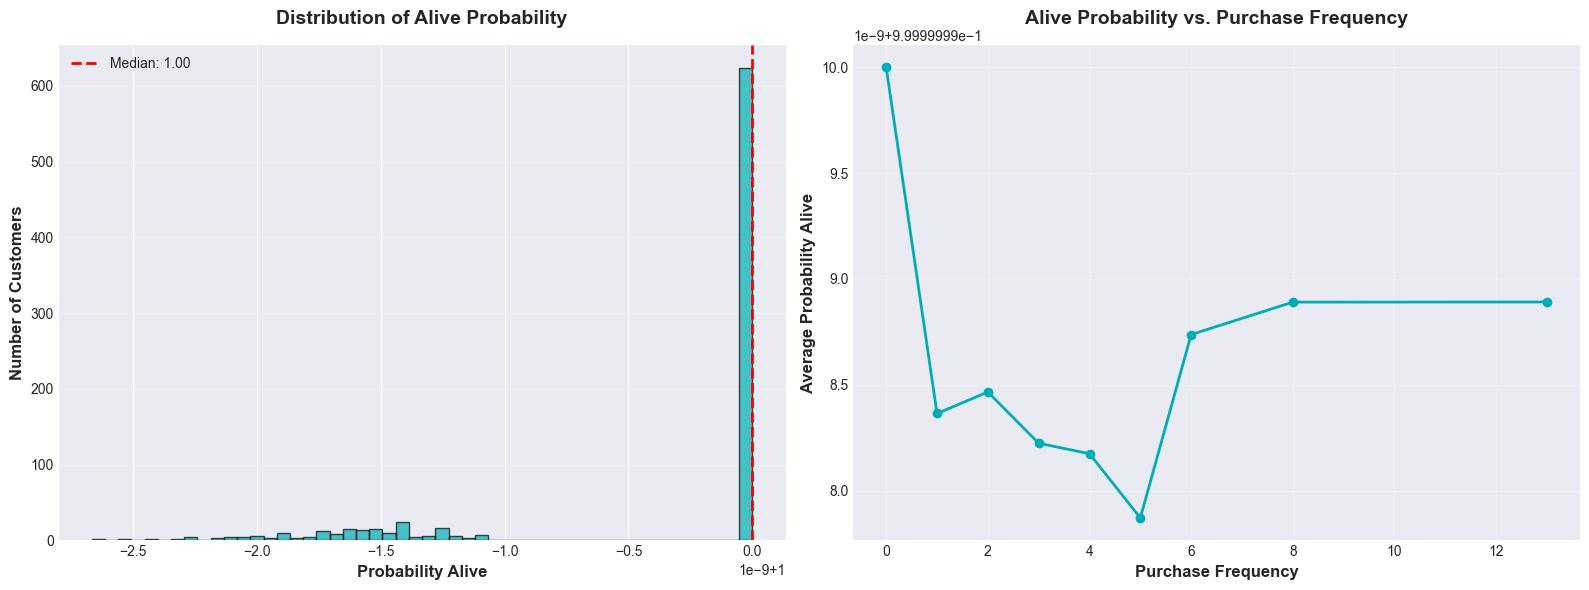


Customers likely alive (>0.5): 815 (100.0%)
Customers likely churned (<0.5): 0 (0.0%)


In [7]:
# ┌────────────────────────────────────────────────────────────┐
# │ Make Predictions: Alive Probability                       │
# └────────────────────────────────────────────────────────────┘

# Predict probability each customer is still "alive"
summary['prob_alive'] = bgf.conditional_probability_alive(
    summary['frequency'],
    summary['recency'],
    summary['T']
)

print("Probability Alive Distribution:")
print("="*80)
print(summary['prob_alive'].describe())

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Distribution
axes[0].hist(summary['prob_alive'], bins=50, color='#00ADB5', alpha=0.7, edgecolor='black')
axes[0].set_xlabel('Probability Alive', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Number of Customers', fontsize=12, fontweight='bold')
axes[0].set_title('Distribution of Alive Probability', fontsize=14, fontweight='bold', pad=15)
axes[0].grid(axis='y', alpha=0.3)
axes[0].axvline(summary['prob_alive'].median(), color='red', linestyle='--', linewidth=2,
                label=f"Median: {summary['prob_alive'].median():.2f}")
axes[0].legend()

# By frequency
freq_groups = summary.groupby('frequency')['prob_alive'].mean()
axes[1].plot(freq_groups.index, freq_groups.values, marker='o', color='#00ADB5', linewidth=2)
axes[1].set_xlabel('Purchase Frequency', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Average Probability Alive', fontsize=12, fontweight='bold')
axes[1].set_title('Alive Probability vs. Purchase Frequency', fontsize=14, fontweight='bold', pad=15)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(DIR_FIGURES / '14_alive_probability.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nCustomers likely alive (>0.5): {(summary['prob_alive'] > 0.5).sum()} ({(summary['prob_alive'] > 0.5).sum()/len(summary)*100:.1f}%)")
print(f"Customers likely churned (<0.5): {(summary['prob_alive'] <= 0.5).sum()} ({(summary['prob_alive'] <= 0.5).sum()/len(summary)*100:.1f}%)")

In [8]:
# ┌────────────────────────────────────────────────────────────┐
# │ Make Predictions: Future Purchases                        │
# └────────────────────────────────────────────────────────────┘

# Predict purchases in next 30, 60, 90, 180, 365 days
time_horizons = [30, 60, 90, 180, 365]

for days in time_horizons:
    col_name = f'predicted_purchases_{days}d'
    summary[col_name] = bgf.predict(
        days,
        summary['frequency'],
        summary['recency'],
        summary['T']
    )

print("Predicted Purchases (Sample Customers):")
print("="*80)
display(summary[['frequency', 'recency', 'T', 'prob_alive', 
                 'predicted_purchases_30d', 'predicted_purchases_90d', 
                 'predicted_purchases_365d']].head(15))

# Statistics
print("\nPrediction Summary:")
for days in time_horizons:
    col = f'predicted_purchases_{days}d'
    print(f"  {days:>3} days: {summary[col].mean():.3f} purchases on average (median: {summary[col].median():.3f})")

Predicted Purchases (Sample Customers):


,frequency,recency,T,prob_alive,predicted_purchases_30d,predicted_purchases_90d,predicted_purchases_365d
CustomerID,,,,,,,
12747,1.0000,8.0000,18.0000,1.0000,1.0600,3.1800,12.8965
12748,13.0000,22.0000,22.0000,1.0000,7.8335,23.5006,95.3080
12826,0.0000,0.0000,14.0000,1.0000,0.4814,1.4442,5.8570
12829,0.0000,0.0000,9.0000,1.0000,0.5423,1.6269,6.5979
12838,0.0000,0.0000,22.0000,1.0000,0.4081,1.2242,4.9648
12839,1.0000,10.0000,16.0000,1.0000,1.1056,3.3167,13.4509
12841,1.0000,2.0000,20.0000,1.0000,1.0180,3.0541,12.3860
12855,0.0000,0.0000,21.0000,1.0000,0.4160,1.2480,5.0612
12867,0.0000,0.0000,9.0000,1.0000,0.5423,1.6269,6.5979



Prediction Summary:
   30 days: 0.702 purchases on average (median: 0.516)
   60 days: 1.404 purchases on average (median: 1.032)
   90 days: 2.107 purchases on average (median: 1.549)
  180 days: 4.213 purchases on average (median: 3.097)
  365 days: 8.543 purchases on average (median: 6.280)


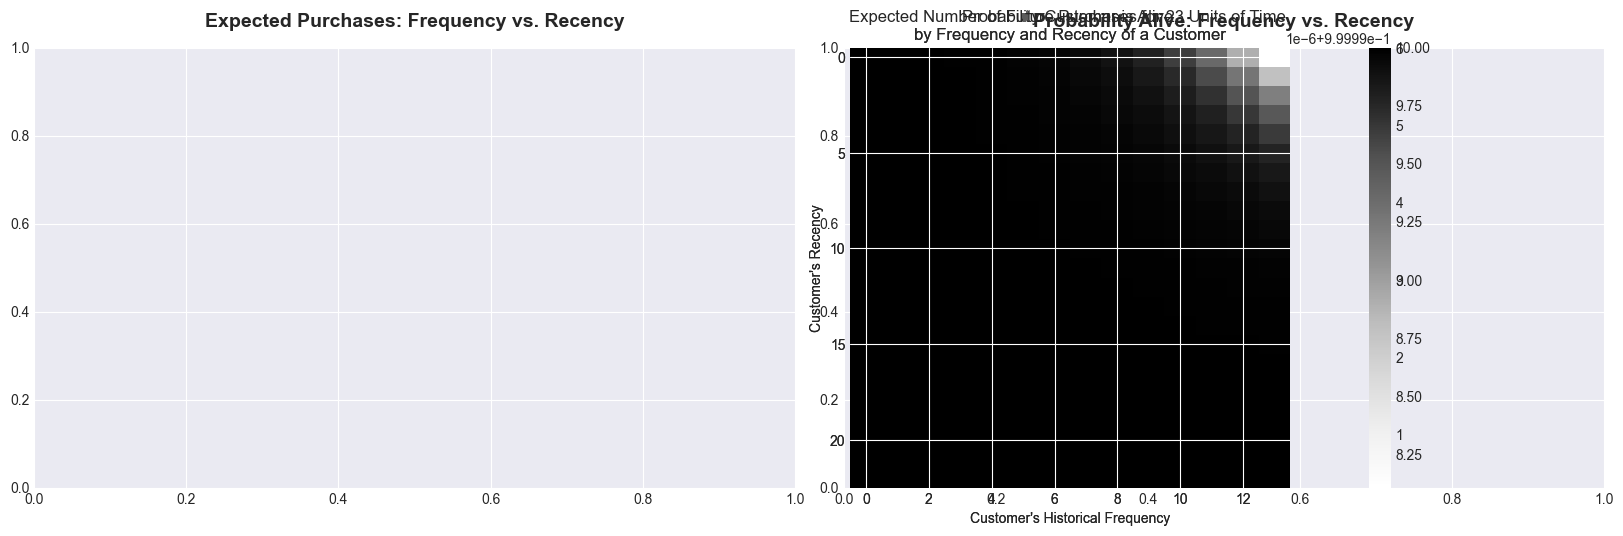

In [9]:
# ┌────────────────────────────────────────────────────────────┐
# │ Visualize BG/NBD Model Fit                                │
# └────────────────────────────────────────────────────────────┘

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Frequency/Recency matrix
plt.sca(axes[0])
plot_frequency_recency_matrix(bgf, T=23)
axes[0].set_title('Expected Purchases: Frequency vs. Recency', fontsize=14, fontweight='bold', pad=15)

# Probability alive matrix
plt.sca(axes[1])
plot_probability_alive_matrix(bgf)
axes[1].set_title('Probability Alive: Frequency vs. Recency', fontsize=14, fontweight='bold', pad=15)

plt.tight_layout()
plt.savefig(DIR_FIGURES / '15_bgf_model_fit.png', dpi=300, bbox_inches='tight')
plt.show()

---

## 6. Gamma-Gamma Model for Monetary Value

╔════════════════════════════════════════════════════════════════╗
║                  GAMMA-GAMMA MODEL THEORY                       ║
╚════════════════════════════════════════════════════════════════╝

### What it predicts:
Average transaction value for future purchases

### Key Assumptions:
1. **Transaction value varies randomly** around customer's average
2. **Average varies between customers** (heterogeneity)
3. **Independent of purchase frequency** (different from BG/NBD)

### Mathematical Model:
```
Each customer has an average transaction value μ
μ follows a Gamma distribution across customers
Individual transactions vary around μ (also Gamma distributed)
```

**Combines:**
- Historical average spend per customer
- Population average
- More purchases → more weight on individual average
- Fewer purchases → more weight on population average

**Note:** Only use customers with frequency > 0 (at least 2 purchases) for Gamma-Gamma!

In [10]:
# ┌────────────────────────────────────────────────────────────┐
# │ Prepare Data for Gamma-Gamma Model                        │
# └────────────────────────────────────────────────────────────┘

# Filter: Only customers with repeat purchases
returning_customers = summary[summary['frequency'] > 0].copy()

print("Gamma-Gamma Data:")
print("="*80)
print(f"Total customers: {len(summary):,}")
print(f"Returning customers (freq > 0): {len(returning_customers):,} ({len(returning_customers)/len(summary)*100:.1f}%)")
print(f"One-time customers: {len(summary) - len(returning_customers):,}")

print(f"\nMonetary value statistics (returning customers):")
display(returning_customers['monetary_value'].describe())

Gamma-Gamma Data:
Total customers: 815
Returning customers (freq > 0): 192 (23.6%)
One-time customers: 623

Monetary value statistics (returning customers):


count    192.0000
mean     473.2536
std      643.1546
min        5.5000
25%      174.2050
50%      289.0350
75%      397.2713
max     3891.8700
Name: monetary_value, dtype: float64

In [11]:
# ┌────────────────────────────────────────────────────────────┐
# │ Train Gamma-Gamma Model                                   │
# └────────────────────────────────────────────────────────────┘

print("Training Gamma-Gamma model...\n")

# Initialize model
ggf = GammaGammaFitter(penalizer_coef=0.0)

# Fit model
ggf.fit(
    returning_customers['frequency'],
    returning_customers['monetary_value']
)

print("✅ Gamma-Gamma model trained successfully!\n")
print("Learned Parameters:")
print("="*80)
print(ggf.summary)

print("\nParameter Interpretation:")
print("  p, q, v: Shape parameters controlling distribution of average transaction values")
print(f"\nPopulation average transaction value: £{returning_customers['monetary_value'].mean():.2f}")

Training Gamma-Gamma model...

✅ Gamma-Gamma model trained successfully!

Learned Parameters:
      coef  se(coef)  lower 95% bound  upper 95% bound
p   1.9118    0.3197           1.2852           2.5384
q   2.4844    0.4214           1.6584           3.3104
v 370.1298  124.9458         125.2361         615.0235

Parameter Interpretation:
  p, q, v: Shape parameters controlling distribution of average transaction values

Population average transaction value: £473.25


Predicted vs. Actual Average Transaction Values:


,frequency,monetary_value,predicted_avg_value
CustomerID,,,
12747,1.0000,347.7100,404.0959
12748,13.0000,324.8600,333.4185
12839,1.0000,334.8400,396.8509
12841,1.0000,211.7400,327.5538
12921,1.0000,365.4000,414.0542
12967,1.0000,292.5000,373.0163
12971,4.0000,97.7675,159.3665
13050,3.0000,290.6200,328.8811
13069,1.0000,311.6200,383.7796



Historical average: £473.25
Predicted average: £479.78


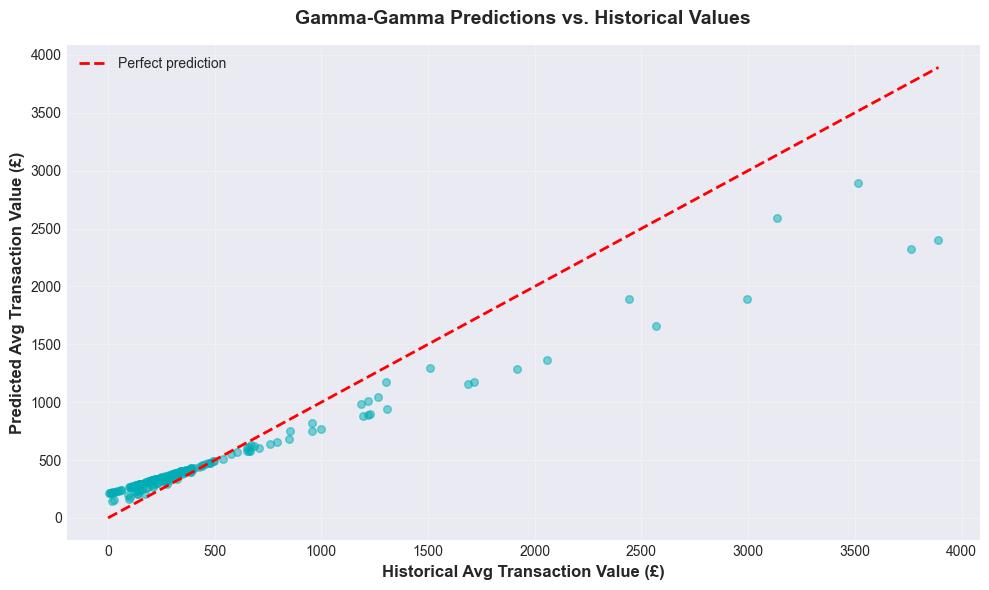

In [12]:
# ┌────────────────────────────────────────────────────────────┐
# │ Predict Expected Transaction Values                       │
# └────────────────────────────────────────────────────────────┘

# Predict expected average transaction value for each customer
returning_customers['predicted_avg_value'] = ggf.conditional_expected_average_profit(
    returning_customers['frequency'],
    returning_customers['monetary_value']
)

print("Predicted vs. Actual Average Transaction Values:")
print("="*80)
display(returning_customers[['frequency', 'monetary_value', 'predicted_avg_value']].head(15))

# Compare historical vs. predicted
print(f"\nHistorical average: £{returning_customers['monetary_value'].mean():.2f}")
print(f"Predicted average: £{returning_customers['predicted_avg_value'].mean():.2f}")

# Visualization
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(returning_customers['monetary_value'], 
           returning_customers['predicted_avg_value'],
           alpha=0.5, color='#00ADB5', s=30)
ax.plot([0, returning_customers['monetary_value'].max()],
        [0, returning_customers['monetary_value'].max()],
        'r--', linewidth=2, label='Perfect prediction')
ax.set_xlabel('Historical Avg Transaction Value (£)', fontsize=12, fontweight='bold')
ax.set_ylabel('Predicted Avg Transaction Value (£)', fontsize=12, fontweight='bold')
ax.set_title('Gamma-Gamma Predictions vs. Historical Values', fontsize=14, fontweight='bold', pad=15)
ax.grid(alpha=0.3)
ax.legend()
plt.tight_layout()
plt.savefig(DIR_FIGURES / '16_gamma_gamma_predictions.png', dpi=300, bbox_inches='tight')
plt.show()

---

## 7. Calculate Customer Lifetime Value

╔════════════════════════════════════════════════════════════════╗
║              CUSTOMER LIFETIME VALUE CALCULATION                ║
╚════════════════════════════════════════════════════════════════╝

### CLV Formula:
```
CLV = (Predicted Purchases) × (Predicted Avg Transaction Value)
```

### Time Horizons:
- Short-term: 90 days
- Medium-term: 180 days
- Long-term: 365 days

### For One-Time Customers:
Use population average transaction value (no Gamma-Gamma prediction)

In [13]:
# ┌────────────────────────────────────────────────────────────┐
# │ Calculate CLV for All Customers                           │
# └────────────────────────────────────────────────────────────┘

# Merge returning customer predictions back to full summary
summary = summary.merge(
    returning_customers[['predicted_avg_value']],
    left_index=True,
    right_index=True,
    how='left'
)

# For one-time customers, use population average
population_avg_value = returning_customers['monetary_value'].mean()
summary['predicted_avg_value'].fillna(population_avg_value, inplace=True)

# Calculate CLV for different time periods
for days in [90, 180, 365]:
    purchases_col = f'predicted_purchases_{days}d'
    clv_col = f'CLV_{days}d'
    
    summary[clv_col] = summary[purchases_col] * summary['predicted_avg_value']

print("Customer Lifetime Value Predictions:")
print("="*80)
display(summary[['frequency', 'monetary_value', 'prob_alive',
                 'predicted_purchases_90d', 'predicted_avg_value', 
                 'CLV_90d', 'CLV_180d', 'CLV_365d']].head(15))

# Summary statistics
print("\nCLV Statistics:")
print("="*80)
for days in [90, 180, 365]:
    clv_col = f'CLV_{days}d'
    print(f"\n{days}-day CLV:")
    print(f"  Mean: £{summary[clv_col].mean():.2f}")
    print(f"  Median: £{summary[clv_col].median():.2f}")
    print(f"  Total (all customers): £{summary[clv_col].sum():,.2f}")

Customer Lifetime Value Predictions:


,frequency,monetary_value,prob_alive,predicted_purchases_90d,predicted_avg_value,CLV_90d,CLV_180d,CLV_365d
CustomerID,,,,,,,,
12747,1.0000,347.7100,1.0000,3.1800,404.0959,1285.0073,2570.0146,5211.4186
12748,13.0000,324.8600,1.0000,23.5006,333.4185,7835.5359,15671.0717,31777.4500
12826,0.0000,0.0000,1.0000,1.4442,473.2536,683.4633,1366.9267,2771.8235
12829,0.0000,0.0000,1.0000,1.6269,473.2536,769.9296,1539.8592,3122.4923
12838,0.0000,0.0000,1.0000,1.2242,473.2536,579.3601,1158.7202,2349.6270
12839,1.0000,334.8400,1.0000,3.3167,396.8509,1316.2213,2632.4426,5338.0086
12841,1.0000,211.7400,1.0000,3.0541,327.5538,1000.3732,2000.7463,4057.0689
12855,0.0000,0.0000,1.0000,1.2480,473.2536,590.6050,1181.2100,2395.2314
12867,0.0000,0.0000,1.0000,1.6269,473.2536,769.9296,1539.8592,3122.4923



CLV Statistics:

90-day CLV:
  Mean: £1009.34
  Median: £732.84
  Total (all customers): £822,609.93

180-day CLV:
  Mean: £2018.67
  Median: £1465.69
  Total (all customers): £1,645,219.87

365-day CLV:
  Mean: £4093.42
  Median: £2972.09
  Total (all customers): £3,336,140.26


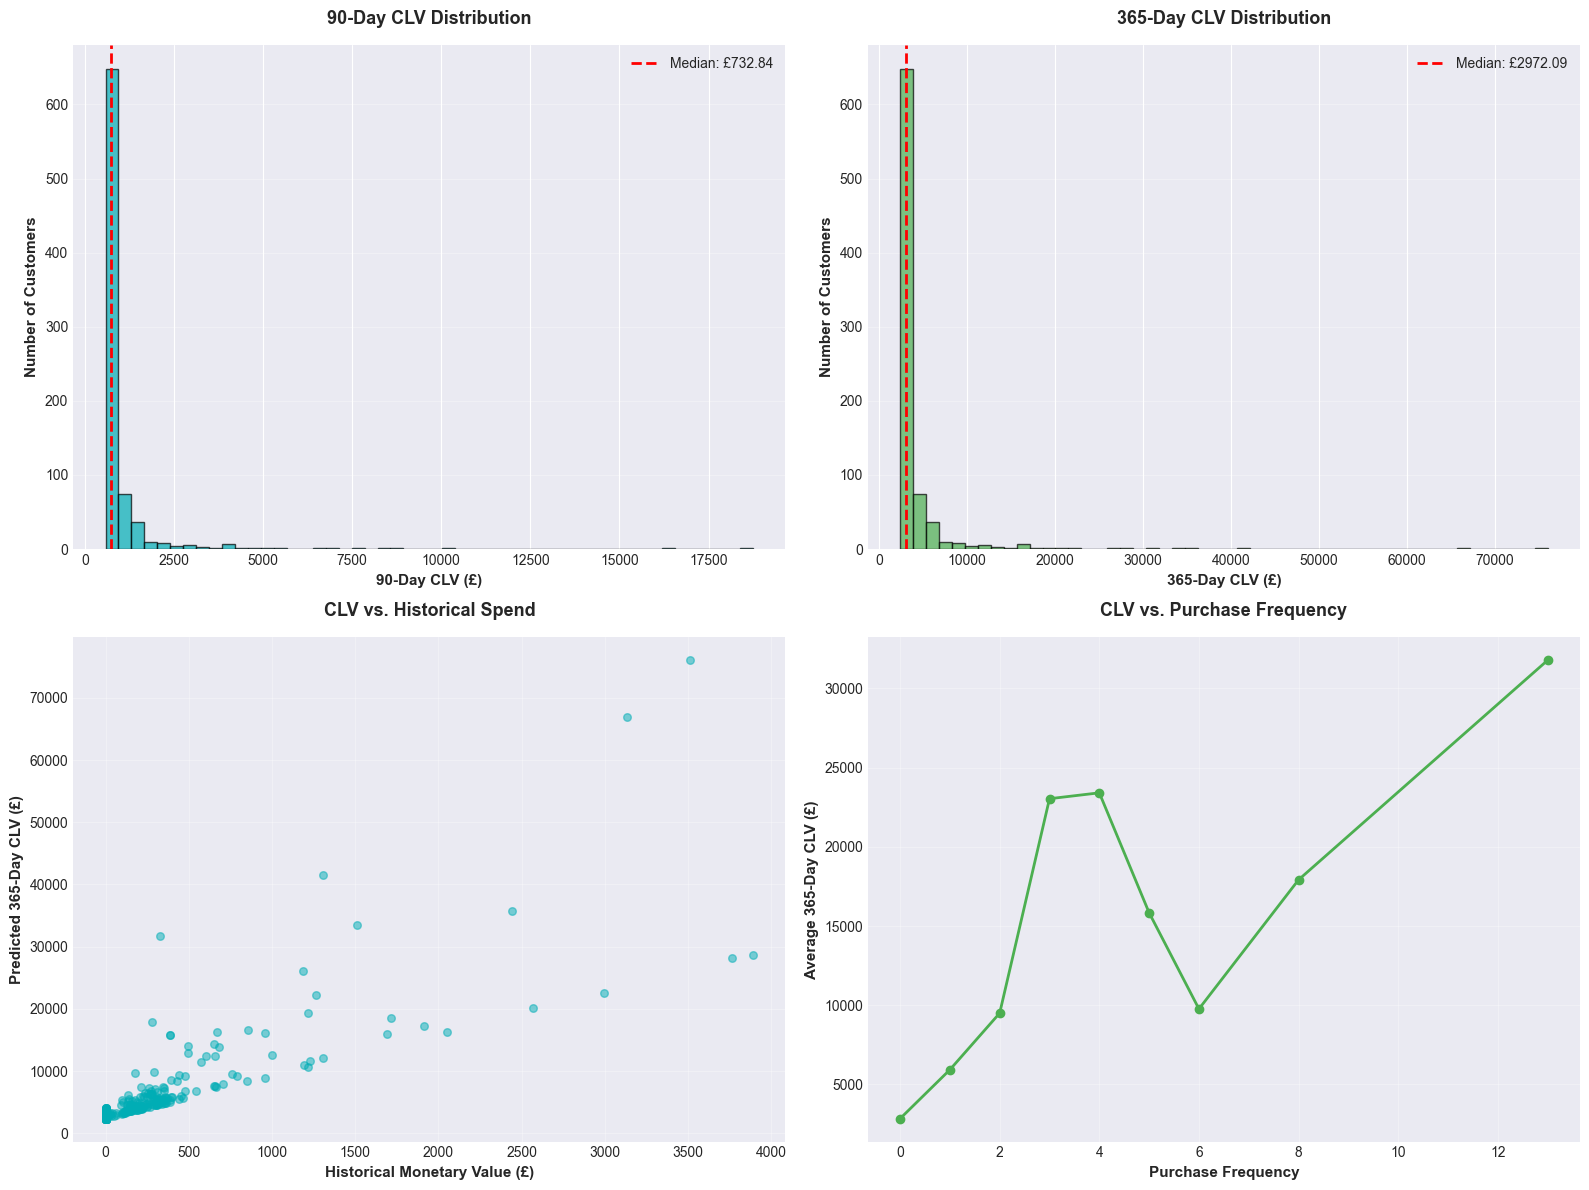

In [14]:
# ┌────────────────────────────────────────────────────────────┐
# │ Visualize CLV Distribution                                │
# └────────────────────────────────────────────────────────────┘

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 90-day CLV distribution
axes[0, 0].hist(summary['CLV_90d'], bins=50, color='#00ADB5', alpha=0.7, edgecolor='black')
axes[0, 0].set_xlabel('90-Day CLV (£)', fontsize=11, fontweight='bold')
axes[0, 0].set_ylabel('Number of Customers', fontsize=11, fontweight='bold')
axes[0, 0].set_title('90-Day CLV Distribution', fontsize=13, fontweight='bold', pad=15)
axes[0, 0].grid(axis='y', alpha=0.3)
axes[0, 0].axvline(summary['CLV_90d'].median(), color='red', linestyle='--', linewidth=2,
                   label=f"Median: £{summary['CLV_90d'].median():.2f}")
axes[0, 0].legend()

# 365-day CLV distribution
axes[0, 1].hist(summary['CLV_365d'], bins=50, color='#4CAF50', alpha=0.7, edgecolor='black')
axes[0, 1].set_xlabel('365-Day CLV (£)', fontsize=11, fontweight='bold')
axes[0, 1].set_ylabel('Number of Customers', fontsize=11, fontweight='bold')
axes[0, 1].set_title('365-Day CLV Distribution', fontsize=13, fontweight='bold', pad=15)
axes[0, 1].grid(axis='y', alpha=0.3)
axes[0, 1].axvline(summary['CLV_365d'].median(), color='red', linestyle='--', linewidth=2,
                   label=f"Median: £{summary['CLV_365d'].median():.2f}")
axes[0, 1].legend()

# CLV vs. Historical Monetary Value
axes[1, 0].scatter(summary['monetary_value'], summary['CLV_365d'], 
                   alpha=0.5, color='#00ADB5', s=30)
axes[1, 0].set_xlabel('Historical Monetary Value (£)', fontsize=11, fontweight='bold')
axes[1, 0].set_ylabel('Predicted 365-Day CLV (£)', fontsize=11, fontweight='bold')
axes[1, 0].set_title('CLV vs. Historical Spend', fontsize=13, fontweight='bold', pad=15)
axes[1, 0].grid(alpha=0.3)

# CLV vs. Frequency
freq_clv = summary.groupby('frequency')['CLV_365d'].mean()
axes[1, 1].plot(freq_clv.index, freq_clv.values, marker='o', color='#4CAF50', linewidth=2)
axes[1, 1].set_xlabel('Purchase Frequency', fontsize=11, fontweight='bold')
axes[1, 1].set_ylabel('Average 365-Day CLV (£)', fontsize=11, fontweight='bold')
axes[1, 1].set_title('CLV vs. Purchase Frequency', fontsize=13, fontweight='bold', pad=15)
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(DIR_FIGURES / '17_clv_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

---

## 8. Validate Predictions on 2011 Data

╔════════════════════════════════════════════════════════════════╗
║                   MODEL VALIDATION                              ║
╚════════════════════════════════════════════════════════════════╝

### Validation Strategy:
1. We trained on Dec 2010 data
2. We have actual 2011 data (339 days)
3. Compare predictions vs. actual behavior

### What to Compare:
- Predicted purchases (90/180/365 days) vs. actual purchases
- Predicted CLV vs. actual revenue generated
- Alive probability vs. actual activity

In [15]:
# ┌────────────────────────────────────────────────────────────┐
# │ Calculate Actual Behavior in Validation Period            │
# └────────────────────────────────────────────────────────────┘

# Get actual purchases and revenue for each customer in validation period
val_summary = val_data.groupby('CustomerID').agg({
    'InvoiceNo': 'nunique',
    'Revenue': 'sum',
    'InvoiceDate': ['min', 'max']
}).reset_index()

val_summary.columns = ['CustomerID', 'actual_purchases', 'actual_revenue', 
                        'first_purchase_val', 'last_purchase_val']

# Calculate days active in validation period
val_start = val_data['InvoiceDate'].min()
val_summary['days_to_first_purchase'] = (val_summary['first_purchase_val'] - val_start).dt.days

print("Validation Period Actual Behavior:")
print("="*80)
print(f"Validation period: {val_data['InvoiceDate'].min().date()} to {val_data['InvoiceDate'].max().date()}")
print(f"Duration: {(val_data['InvoiceDate'].max() - val_data['InvoiceDate'].min()).days} days\n")

display(val_summary.head(15))

print(f"\nValidation Summary:")
print(f"  Customers who purchased: {len(val_summary):,}")
print(f"  Total purchases: {val_summary['actual_purchases'].sum():,}")
print(f"  Total revenue: £{val_summary['actual_revenue'].sum():,.2f}")
print(f"  Avg purchases per customer: {val_summary['actual_purchases'].mean():.2f}")
print(f"  Avg revenue per customer: £{val_summary['actual_revenue'].mean():.2f}")

Validation Period Actual Behavior:
Validation period: 2011-01-04 to 2011-12-09
Duration: 339 days



,CustomerID,actual_purchases,actual_revenue,first_purchase_val,last_purchase_val,days_to_first_purchase
0,12346,1,77183.6000,2011-01-18 10:01:00,2011-01-18 10:01:00,14
1,12747,9,3489.7400,2011-01-20 14:01:00,2011-12-07 14:34:00,16
2,12748,174,29491.6000,2011-01-05 16:06:00,2011-12-09 12:20:00,1
3,12749,5,4090.8800,2011-05-10 15:25:00,2011-12-06 09:56:00,126
4,12820,4,942.3400,2011-01-17 12:34:00,2011-12-06 15:12:00,13
5,12821,1,92.7200,2011-05-09 15:51:00,2011-05-09 15:51:00,125
6,12822,2,948.8800,2011-09-13 13:46:00,2011-09-30 10:04:00,252
7,12823,5,1759.5000,2011-02-16 12:15:00,2011-09-26 07:35:00,43
8,12824,1,397.1200,2011-10-11 12:49:00,2011-10-11 12:49:00,280
9,12826,6,1319.7200,2011-01-19 12:52:00,2011-12-07 10:25:00,15



Validation Summary:
  Customers who purchased: 3,813
  Total purchases: 15,355
  Total revenue: £6,809,729.70
  Avg purchases per customer: 4.03
  Avg revenue per customer: £1785.92


In [16]:
# ┌────────────────────────────────────────────────────────────┐
# │ Merge Predictions with Actual Behavior                    │
# └────────────────────────────────────────────────────────────┘

# Add CustomerID back to summary for merge
summary_with_id = summary.reset_index()

# Merge predictions with actual
validation_comparison = summary_with_id.merge(
    val_summary[['CustomerID', 'actual_purchases', 'actual_revenue', 'days_to_first_purchase']],
    on='CustomerID',
    how='left'
)

# Fill NaN (customers who didn't purchase in validation) with 0
validation_comparison['actual_purchases'].fillna(0, inplace=True)
validation_comparison['actual_revenue'].fillna(0, inplace=True)

# Mark customers as active or churned
validation_comparison['actually_active'] = (validation_comparison['actual_purchases'] > 0).astype(int)

print("Prediction vs. Actual Comparison:")
print("="*80)
display(validation_comparison[['CustomerID', 'frequency', 'prob_alive', 
                                'predicted_purchases_365d', 'actual_purchases',
                                'CLV_365d', 'actual_revenue', 'actually_active']].head(20))

# Calculate prediction accuracy metrics
print("\nValidation Metrics:")
print("="*80)

# Who was active?
n_predicted_active = (validation_comparison['prob_alive'] > 0.5).sum()
n_actually_active = validation_comparison['actually_active'].sum()
print(f"Predicted active (prob > 0.5): {n_predicted_active} ({n_predicted_active/len(validation_comparison)*100:.1f}%)")
print(f"Actually active: {n_actually_active} ({n_actually_active/len(validation_comparison)*100:.1f}%)")

# Correlation between predicted and actual
# Only for customers who were active
active_customers = validation_comparison[validation_comparison['actually_active'] == 1]
purchase_corr = active_customers['predicted_purchases_365d'].corr(active_customers['actual_purchases'])
revenue_corr = active_customers['CLV_365d'].corr(active_customers['actual_revenue'])

print(f"\nPrediction Correlations (active customers only):")
print(f"  Predicted vs. Actual Purchases: {purchase_corr:.3f}")
print(f"  Predicted vs. Actual Revenue: {revenue_corr:.3f}")

Prediction vs. Actual Comparison:


,CustomerID,frequency,prob_alive,predicted_purchases_365d,actual_purchases,CLV_365d,actual_revenue,actually_active
0,12747,1.0000,1.0000,12.8965,9.0000,5211.4186,3489.7400,1
1,12748,13.0000,1.0000,95.3080,174.0000,31777.4500,29491.6000,1
2,12826,0.0000,1.0000,5.8570,6.0000,2771.8235,1319.7200,1
3,12829,0.0000,1.0000,6.5979,1.0000,3122.4923,207.2500,1
4,12838,0.0000,1.0000,4.9648,1.0000,2349.6270,292.3400,1
5,12839,1.0000,1.0000,13.4509,12.0000,5338.0086,4853.9700,1
6,12841,1.0000,1.0000,12.3860,23.0000,4057.0689,3516.3600,1
7,12855,0.0000,1.0000,5.0612,0.0000,2395.2314,0.0000,0
8,12867,0.0000,1.0000,6.5979,6.0000,3122.4923,3674.0300,1
9,12868,0.0000,1.0000,4.9648,5.0000,2349.6270,1403.7600,1



Validation Metrics:
Predicted active (prob > 0.5): 815 (100.0%)
Actually active: 708 (86.9%)

Prediction Correlations (active customers only):
  Predicted vs. Actual Purchases: 0.699
  Predicted vs. Actual Revenue: 0.427


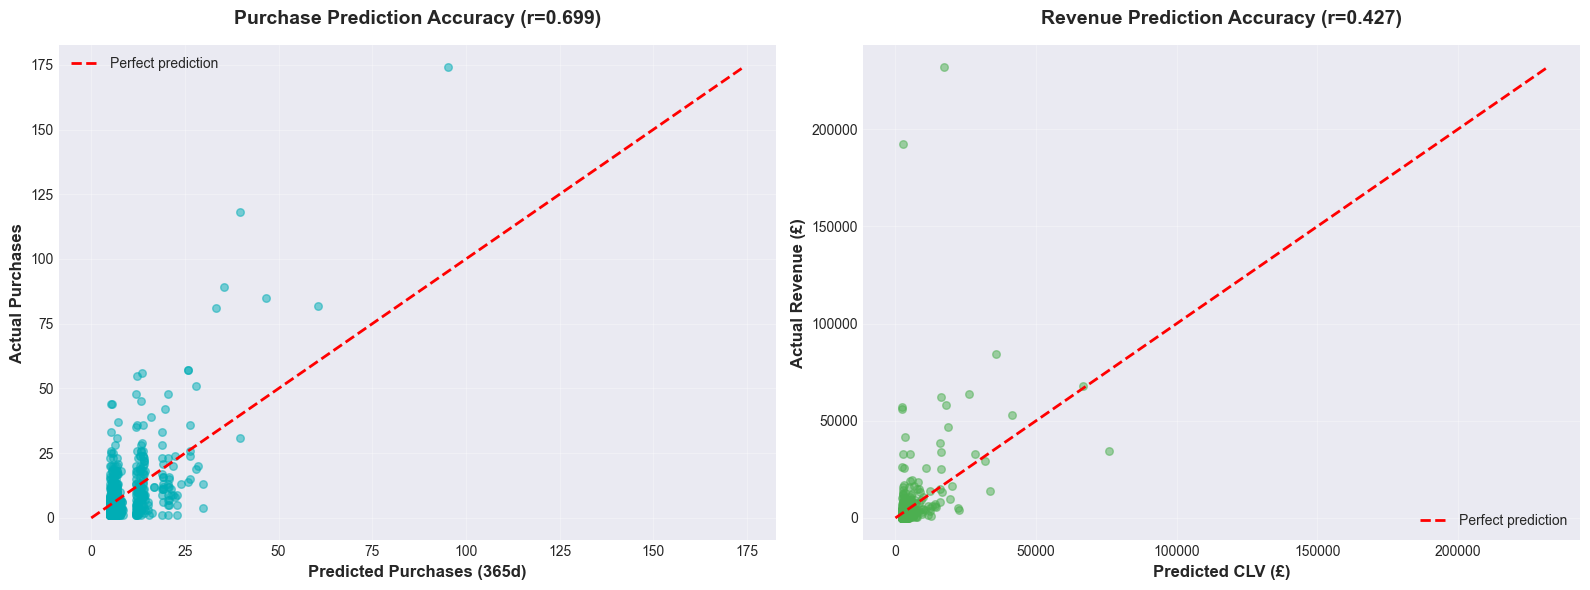

In [17]:
# ┌────────────────────────────────────────────────────────────┐
# │ Visualize Validation Results                              │
# └────────────────────────────────────────────────────────────┘

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Predicted vs Actual Purchases
axes[0].scatter(active_customers['predicted_purchases_365d'],
                active_customers['actual_purchases'],
                alpha=0.5, color='#00ADB5', s=30)
max_val = max(active_customers['predicted_purchases_365d'].max(),
              active_customers['actual_purchases'].max())
axes[0].plot([0, max_val], [0, max_val], 'r--', linewidth=2, label='Perfect prediction')
axes[0].set_xlabel('Predicted Purchases (365d)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Actual Purchases', fontsize=12, fontweight='bold')
axes[0].set_title(f'Purchase Prediction Accuracy (r={purchase_corr:.3f})', 
                  fontsize=14, fontweight='bold', pad=15)
axes[0].grid(alpha=0.3)
axes[0].legend()

# Predicted vs Actual Revenue
axes[1].scatter(active_customers['CLV_365d'],
                active_customers['actual_revenue'],
                alpha=0.5, color='#4CAF50', s=30)
max_val = max(active_customers['CLV_365d'].max(),
              active_customers['actual_revenue'].max())
axes[1].plot([0, max_val], [0, max_val], 'r--', linewidth=2, label='Perfect prediction')
axes[1].set_xlabel('Predicted CLV (£)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Actual Revenue (£)', fontsize=12, fontweight='bold')
axes[1].set_title(f'Revenue Prediction Accuracy (r={revenue_corr:.3f})', 
                  fontsize=14, fontweight='bold', pad=15)
axes[1].grid(alpha=0.3)
axes[1].legend()

plt.tight_layout()
plt.savefig(DIR_FIGURES / '18_validation_results.png', dpi=300, bbox_inches='tight')
plt.show()

---

## 9. Export Results

╔════════════════════════════════════════════════════════════════╗
║                    EXPORT MODELS & PREDICTIONS                  ║
╚════════════════════════════════════════════════════════════════╝

In [18]:
# ┌────────────────────────────────────────────────────────────┐
# │ Save Trained Models                                        │
# └────────────────────────────────────────────────────────────┘

print("Saving models...\n")

# Save BG/NBD model
with open(DIR_MODELS / 'bgf_model.pkl', 'wb') as f:
    dill.dump(bgf, f)
print("✅ BG/NBD model saved")

# Save Gamma-Gamma model
with open(DIR_MODELS / 'ggf_model.pkl', 'wb') as f:
    dill.dump(ggf, f)
print("✅ Gamma-Gamma model saved")

# Save model parameters as JSON for reference
model_params = {
    'bgf_params': {
        'r': float(bgf.params_['r']),
        'alpha': float(bgf.params_['alpha']),
        'a': float(bgf.params_['a']),
        'b': float(bgf.params_['b'])
    },
    'ggf_params': {
        'p': float(ggf.params_['p']),
        'q': float(ggf.params_['q']),
        'v': float(ggf.params_['v'])
    }
}

with open(DIR_MODELS / 'model_parameters.json', 'w') as f:
    json.dump(model_params, f, indent=2)
print("✅ Model parameters saved")


Saving models...

✅ BG/NBD model saved
✅ Gamma-Gamma model saved
✅ Model parameters saved


In [19]:
# ┌────────────────────────────────────────────────────────────┐
# │ Save CLV Predictions                                       │
# └────────────────────────────────────────────────────────────┘

print("Saving predictions...\n")

# Save full predictions with validation data
validation_comparison.to_csv(DIR_DATA_PROCESSED / 'customer_clv_predictions.csv', index=False)
print(f"✅ CLV predictions saved: {len(validation_comparison):,} customers")

# Create summary report
summary_report = pd.DataFrame({
    'Metric': [
        'Training Customers',
        'Returning Customers',
        'One-time Customers',
        'Median Alive Probability',
        'Predicted Active (>0.5)',
        'Actually Active in 2011',
        'Avg Predicted 365d Purchases',
        'Avg Actual Purchases',
        'Avg Predicted 365d CLV (£)',
        'Avg Actual Revenue (£)',
        'Purchase Prediction Correlation',
        'Revenue Prediction Correlation',
        'Total Predicted 365d CLV (£)',
        'Total Actual Revenue (£)'
    ],
    'Value': [
        f"{len(summary):,}",
        f"{len(returning_customers):,}",
        f"{len(summary) - len(returning_customers):,}",
        f"{summary['prob_alive'].median():.3f}",
        f"{n_predicted_active:,}",
        f"{n_actually_active:,}",
        f"{validation_comparison['predicted_purchases_365d'].mean():.2f}",
        f"{validation_comparison['actual_purchases'].mean():.2f}",
        f"£{validation_comparison['CLV_365d'].mean():.2f}",
        f"£{validation_comparison['actual_revenue'].mean():.2f}",
        f"{purchase_corr:.3f}",
        f"{revenue_corr:.3f}",
        f"£{validation_comparison['CLV_365d'].sum():,.2f}",
        f"£{validation_comparison['actual_revenue'].sum():,.2f}"
    ]
})

summary_report.to_csv(DIR_RESULTS / 'outputs' / 'clv_model_summary.csv', index=False)
print("✅ Model summary saved")

print("\n" + "="*80)
print("MODEL SUMMARY")
print("="*80)
display(summary_report)

Saving predictions...

✅ CLV predictions saved: 815 customers
✅ Model summary saved

MODEL SUMMARY


,Metric,Value
0,Training Customers,815
1,Returning Customers,192
2,One-time Customers,623
3,Median Alive Probability,1.000
4,Predicted Active (>0.5),815
5,Actually Active in 2011,708
6,Avg Predicted 365d Purchases,8.54
7,Avg Actual Purchases,7.58
8,Avg Predicted 365d CLV (£),£4093.42
9,Avg Actual Revenue (£),£3829.01


In [20]:
# ┌────────────────────────────────────────────────────────────┐
# │ Final Summary                                              │
# └────────────────────────────────────────────────────────────┘

print("\n" + "═"*80)
print("PROBABILISTIC CLV MODELING COMPLETE")
print("═"*80)

print("\n✅ Models Trained:")
print("   • BG/NBD (purchase frequency prediction)")
print("   • Gamma-Gamma (transaction value prediction)")

print("\n✅ Predictions Generated:")
print(f"   • {len(validation_comparison):,} customers with CLV forecasts")
print("   • Time horizons: 30, 60, 90, 180, 365 days")

print("\n✅ Validation Performed:")
print(f"   • Purchase correlation: {purchase_corr:.3f}")
print(f"   • Revenue correlation: {revenue_corr:.3f}")

print("\n✅ Outputs Created:")
print("   • models/bgf_model.pkl")
print("   • models/ggf_model.pkl")
print("   • models/model_parameters.json")
print("   • data/processed/customer_clv_predictions.csv")
print("   • results/clv_model_summary.csv")
print("   • results/figures/ (5 new visualizations)")

print("\n" + "═"*80)
print("Ready for next step: Churn prediction modeling")
print("═"*80)


════════════════════════════════════════════════════════════════════════════════
PROBABILISTIC CLV MODELING COMPLETE
════════════════════════════════════════════════════════════════════════════════

✅ Models Trained:
   • BG/NBD (purchase frequency prediction)
   • Gamma-Gamma (transaction value prediction)

✅ Predictions Generated:
   • 815 customers with CLV forecasts
   • Time horizons: 30, 60, 90, 180, 365 days

✅ Validation Performed:
   • Purchase correlation: 0.699
   • Revenue correlation: 0.427

✅ Outputs Created:
   • models/bgf_model.pkl
   • models/ggf_model.pkl
   • models/model_parameters.json
   • data/processed/customer_clv_predictions.csv
   • results/clv_model_summary.csv
   • results/figures/ (5 new visualizations)

════════════════════════════════════════════════════════════════════════════════
Ready for next step: Churn prediction modeling
════════════════════════════════════════════════════════════════════════════════
